In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import itertools

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns

import os
from pathlib import Path
project_path = Path(os.getcwd()).parent
import pickle
import joblib 

np.random.seed(2530)

In [2]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=small_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [3]:
from fbprophet import Prophet

### Changepoints

In [4]:
def add_changepoints_to_plot(
    ax, m, fcst, threshold=0.01, cp_color='r', cp_linestyle='--', trend=True,
):
    """Add markers for significant changepoints to prophet forecast plot.

    Example:
    fig = m.plot(forecast)
    add_changepoints_to_plot(fig.gca(), m, forecast)

    Parameters
    ----------
    ax: axis on which to overlay changepoint markers.
    m: Prophet model.
    fcst: Forecast output from m.predict.
    threshold: Threshold on trend change magnitude for significance.
    cp_color: Color of changepoint markers.
    cp_linestyle: Linestyle for changepoint markers.
    trend: If True, will also overlay the trend.

    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if trend:
        artists.append(ax.plot(fcst['ds'], fcst['trend'], c=cp_color))
    signif_changepoints = m.changepoints[
        np.abs(np.nanmean(m.params['delta'], axis=0)) >= threshold
    ] if len(m.changepoints) > 0 else []
    for cp in signif_changepoints:
        artists.append(ax.axvline(x=cp, c=cp_color, ls=cp_linestyle))
    return artists

In [5]:
train = pd.read_parquet('../data/03_train-test/train_data_prophet.parquet')
train = train[:365*48]

In [6]:
%%time
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Wall time: 1min 2s


In [7]:
forecast = m.predict(train)

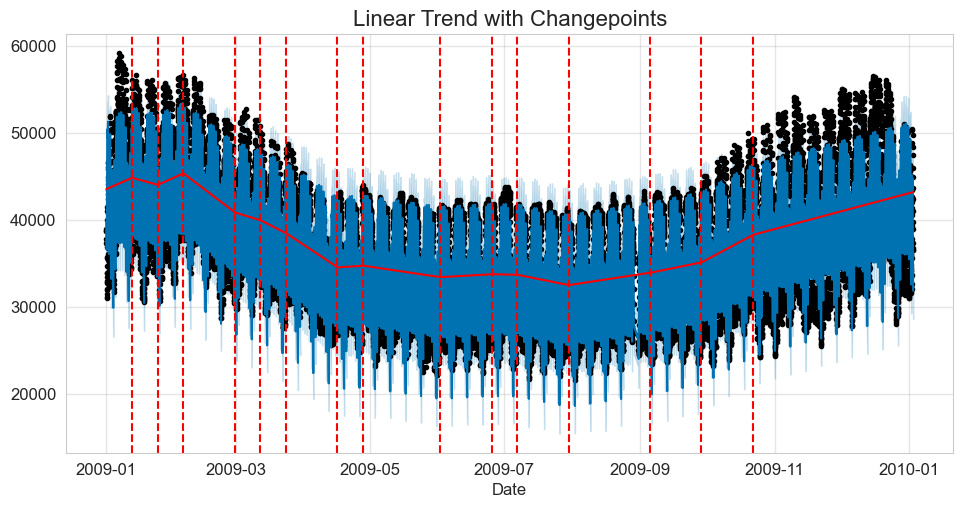

In [12]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast, figsize=(10,5))
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title('Linear Trend with Changepoints')
plt.ylabel('')
plt.xlabel('Date')
plt.savefig("../graphs/changepoints.png")

### Components visualitation

In [21]:
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import num2date, AutoDateLocator, AutoDateFormatter


def seasonality_plot_df(m, ds):
    """Prepare dataframe for plotting seasonal components.

    Parameters
    ----------
    m: Prophet model.
    ds: List of dates for column ds.

    Returns
    -------
    A dataframe with seasonal components on ds.
    """
    df_dict = {'ds': ds, 'cap': 1., 'floor': 0.}
    for name in m.extra_regressors:
        df_dict[name] = 0.
    # Activate all conditional seasonality columns
    for props in m.seasonalities.values():
        if props['condition_name'] is not None:
            df_dict[props['condition_name']] = True
    df = pd.DataFrame(df_dict)
    df = m.setup_dataframe(df)
    return df


def plot_seasonality(m, name, ax=None, uncertainty=True, figsize=(10, 6)):
    """Plot a custom seasonal component.

    Parameters
    ----------
    m: Prophet model.
    name: Seasonality name, like 'daily', 'weekly'.
    ax: Optional matplotlib Axes to plot on. One will be created if
        this is not provided.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    figsize: Optional tuple width, height in inches.

    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if not ax:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    # Compute seasonality from Jan 1 through a single period.
    start = pd.to_datetime('2017-01-01 0000')
    period = m.seasonalities[name]['period']
    end = start + pd.Timedelta(days=period)
    plot_points = 200
    days = pd.to_datetime(np.linspace(start.value, end.value, plot_points))
    df_y = seasonality_plot_df(m, days)
    seas = m.predict_seasonal_components(df_y)
    artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
                        c='#0072B2')
    if uncertainty and m.uncertainty_samples:
        artists += [ax.fill_between(
            df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],
            seas[name + '_upper'], color='#0072B2', alpha=0.2)]
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    n_ticks = 8
    xticks = pd.to_datetime(np.linspace(start.value, end.value, n_ticks)
        ).to_pydatetime()
    ax.set_xticks(xticks)
    if name == 'yearly':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%B} {dt.day}'.format(dt=num2date(x)))
        ax.set_xlabel('Day of year')
    elif name == 'weekly':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%A}'.format(dt=num2date(x)))
        ax.set_xlabel('Day of Week')
    elif name == 'daily':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%T}'.format(dt=num2date(x)))
        ax.set_xlabel('Hour of day')
    elif period <= 2:
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%T}'.format(dt=num2date(x)))
        ax.set_xlabel('Hours')
    else:
        fmt = FuncFormatter(
            lambda x, pos=None: '{:.0f}'.format(pos * period / (n_ticks - 1)))
        ax.set_xlabel('Days')
    ax.xaxis.set_major_formatter(fmt)
    ax.set_ylabel(name)
    if m.seasonalities[name]['mode'] == 'multiplicative':
        ax = set_y_as_percent(ax)
    return artists


def plot_forecast_component(
    m, fcst, name, ax=None, uncertainty=True, plot_cap=False, figsize=(10, 6)
):
    """Plot a particular component of the forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    name: Name of the component to plot.
    ax: Optional matplotlib Axes to plot on.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    figsize: Optional tuple width, height in inches.

    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if not ax:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    fcst_t = fcst['ds'].dt.to_pydatetime()
    artists += ax.plot(fcst_t, fcst[name], ls='-', c='#0072B2')
    if 'cap' in fcst and plot_cap:
        artists += ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
    if uncertainty and m.uncertainty_samples:
        artists += [ax.fill_between(
            fcst_t, fcst[name + '_lower'], fcst[name + '_upper'],
            color='#0072B2', alpha=0.2)]
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel('ds')
    ax.set_ylabel(name)
    if name in m.component_modes['multiplicative']:
        ax = set_y_as_percent(ax)
    return artists




In [5]:
prophet_model = joblib.load(project_path.joinpath('data/models/prophet.pkl')) 
prophet_hol_model = joblib.load(project_path.joinpath('data/models/prophet_hol_model.pkl'))

In [9]:
test_data_prophet = pd.read_parquet('../data/03_train-test/test_data_prophet.parquet')

In [8]:
prophet_predict_df = prophet_model.predict(test_data_prophet)
prophet_hol_predict_df = prophet_hol_model.predict(test_data_prophet)

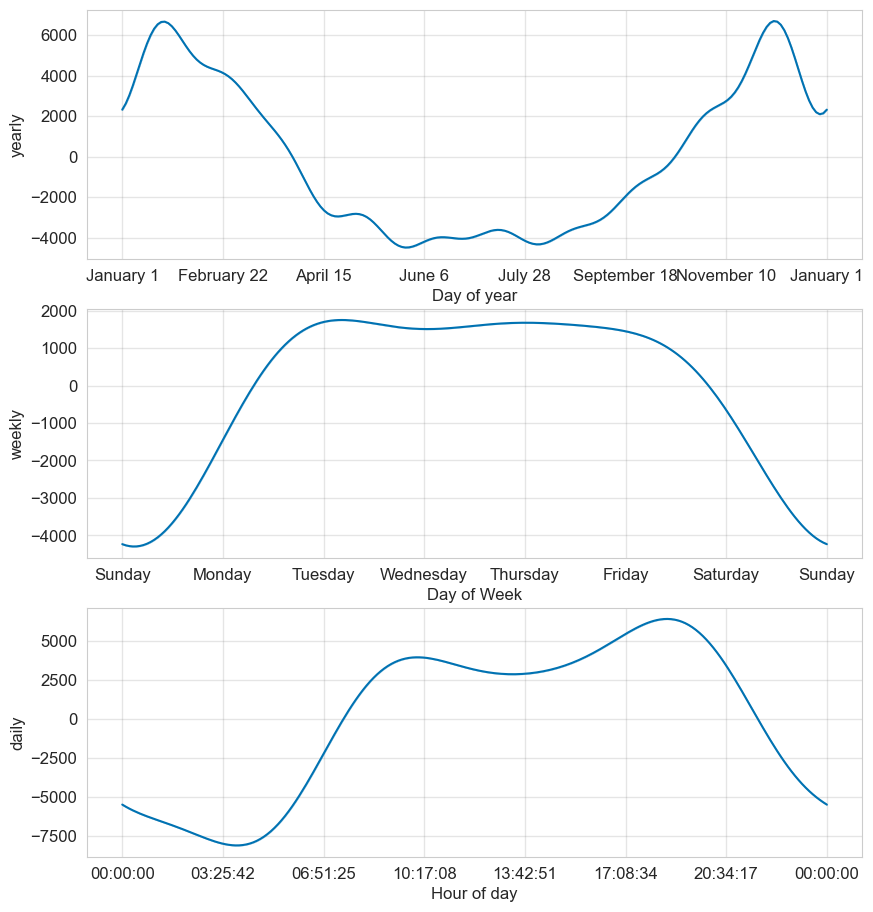

In [24]:
fig, ax = plt.subplots(3, figsize=(10,11))
plot_seasonality(m=prophet_model, name='yearly', ax=ax[0])
plot_seasonality(m=prophet_model, name='weekly', ax=ax[1])
plot_seasonality(m=prophet_model, name='daily', ax=ax[2])
plt.savefig("../graphs/prophet_comp.png")

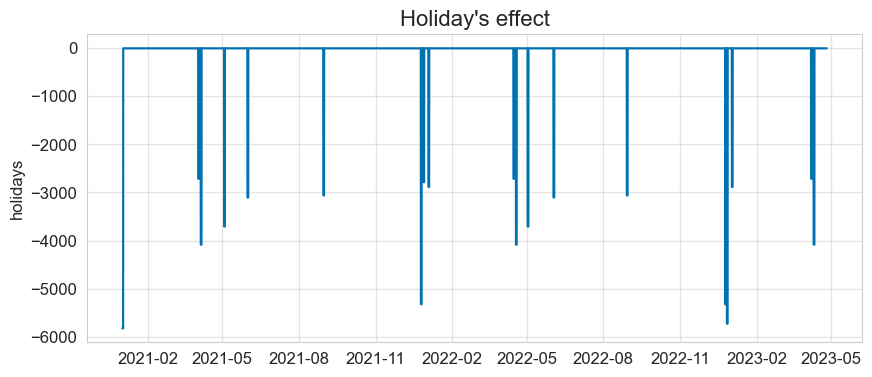

In [32]:
plot_forecast_component(m=prophet_hol_model, fcst=prophet_hol_predict_df, name='holidays', figsize=(10,4))
plt.title('Holiday\'s effect')
plt.xlabel('')
plt.savefig("../graphs/prophet_hday.png")